In [1]:
using DataFrames
using Statistics
using LinearAlgebra
using Dates
using CSV
using Plots
using Combinatorics: combinations
ENV["COLUMNS"]=120

120

In [2]:
# Select an array of stocks, between given dates, at a given daily period
function select_stocks(file_path::String, begin_date::Date, end_date::Date, period::Int64, stock_list::Vector{String})
    data = CSV.read(file_path) |> DataFrame # read in long data
    data = filter(row -> (begin_date <= row.date <= end_date), data) # filter for date range
    data = filter(row -> row.stock ∈ stock_list, data) # filter for stocks in stock_list
    wide_data = unstack(data, :date, :stock, :close) # Create wide table
    sort!(data, [:date]) # Make sure data is sorted by date
    index = 1:period:size(wide_data)[1] # Create an index based on period to subset the rows
    wide_data = wide_data[index, :] # Filter the row based on the index
end

# If stock list is missing, then return whole stock dataframe in wideform
function select_stocks(file_path::String, begin_date::Date, end_date::Date, period::Int64)
    data = CSV.read(file_path) |> DataFrame # read in long data
    stock_list = levels(data.stock)[1:17]
    return select_stocks(file_path::String, begin_date::Date, end_date::Date, period::Int64, stock_list::Vector{String})
end

select_stocks (generic function with 2 methods)

In [3]:
# This a function that returns a set of portfolio returns for each stock
# The returns are in the form of :percentage_change or log_difference
# An unspecified third argument defaults to :percentage_change

function portfolio_returns_table(input::DataFrame, date::Symbol, relative_difference::Symbol = :percentage_change)
    sort!(input, [date])
    input_data = select(input, Not([date]))
    input_names = names(input_data)
    dates = input[!, date]
    L = size(input_data)[1]
    input_matrix = Matrix(input_data)
    input_matrix = float.(input_matrix)
    
    
    if relative_difference == :percentage_change
        #
        ML = input_matrix[2:L, :]
        MR = input_matrix[1:L-1, :]
        MF = (ML .- MR) ./ ML
        MF = MF * 100
    elseif relative_difference == :log_difference
        input_matrix = log.(input_matrix)
        ML = input_matrix[2:L, :]
        MR = input_matrix[1:L-1, :]
        MF = ML .- MR
        MF = MF * 100
    else
        error("Choose :percentage_change or :log_difference for the relative_difference paramater")
    end

    mydates = dates[2:L, :] |> vec
    
    output = DataFrame()
    output[:date] = mydates
    
    for i in eachindex(input_names)
        output[input_names[i]] = MF[:, i]
    end
    
    return output
        
end

portfolio_returns_table (generic function with 2 methods)

In [4]:
# Define the Portfolio struct
mutable struct Portfolio
    equities::Vector{Symbol}
    cov_matrix::Matrix{Float64}
    means::Vector{Float64}
    weights::Vector{Float64}
    
    # Constraint function
    function Portfolio(equities, cov_matrix, means, weights)
        if length(equities) == length(means) == length(weights) == size(cov_matrix)[1] == size(cov_matrix)[2]
            return new(equities, cov_matrix, means, weights)
        else
            error("Check the dimension of inputs")
        end        
    end    
end

In [5]:
# Constructs a portfolio object from a portfolio return table 
# Random weights that add to 1 are assigned 
function portfolio(df_input::DataFrame, date::Symbol)
    df = sort(df_input, [date])
    df = select(df, Not([date]))
    
    # Get the data matrix
    data = Matrix(df)
    
    # Produce the equities, cov_matrix, means and random weights that add to 1
    equities = names(df)
    cov_matrix = Statistics.cov(data)
    means = sum(data, dims = 1) |> vec
    unscaled_weights = rand(length(means))
    weights = unscaled_weights ./ sum(unscaled_weights)
    
    # Returns a Portfolio object
    return Portfolio(equities, cov_matrix, means, weights)
end

portfolio (generic function with 1 method)

In [6]:
# Calculates the expected return of the portfolio
function expected_return(p::Portfolio)
    e_return = transpose(p.weights) * p.means
    return e_return
end

expected_return (generic function with 1 method)

In [7]:
# Calculates the expected risk of the portfolio
function expected_risk(p::Portfolio)
    e_risk_squared = transpose(p.weights) * p.cov_matrix * p.weights
    e_risk = sqrt(e_risk_squared)
    return e_risk   
end

expected_risk (generic function with 1 method)

In [8]:
# Calculates the Sharp ratio of a portfolio
function sharp_ratio(p::Portfolio)
    s_ratio = expected_return(p) / expected_risk(p)
    return s_ratio
end

sharp_ratio (generic function with 1 method)

In [9]:
# Creates a variant of a portfolio, only with a different weights 
function variant(p::Portfolio)
    unscaled_weights = rand(length(p.means))
    new_weights = unscaled_weights ./ sum(unscaled_weights)
    return Portfolio(p.equities, p.cov_matrix, p.means, new_weights)    
end

variant (generic function with 1 method)

In [10]:
# Create a population of portfolios of size N
function create_population(p::Portfolio, N::Int64)
    population = fill(p, N)
    population = variant.(population)
    return population   
end

create_population (generic function with 1 method)

In [11]:
# Creates a child portfolio from 2 parent portfolios by averaging their weights
function reproduce(p1::Portfolio, p2::Portfolio)
    mixed_weights = 0.5 * (p1.weights .+ p2.weights)
    return Portfolio(p1.equities, p1.cov_matrix, p1.means, mixed_weights)
end

# Offspring porfolios are created by mating all pairs in the population 
function reproduce(p_array::Vector{Portfolio})
    idx = 1:length(p_array) |> collect # Create a full index for p_array
    pair_set = combinations(idx, 2) |> collect # Generate all ways to select pairs out the full index
    offspring = [reproduce(p_array[i[1]], p_array[i[2]]) for i in pair_set] # Create offspring portfolios
    new_pop = cat(p_array, offspring, dims = 1) # Merge the parent and offspring portfolios into a single portfolio
    return offspring
end

reproduce (generic function with 2 methods)

In [12]:
# Get the boundary of the efficient frontier
function boundary(p_array::Vector{Portfolio})
    # Create a base df for analysis
    e_risk = expected_risk.(p_array)
    e_return = expected_return.(p_array)
    sr = sharp_ratio.(p_array)
    df = DataFrame(Expected_Return = e_return, Expected_Risk = e_risk, Sharp_Ratio = sr, Portfolio = p_array)
    # code here
    df = filter(row -> row.Expected_Return > 0, df) # Filter for positive expected returns
    df[:er_class] = round.(df.Expected_Return, digits = 1) # Create er_class variable for sorting/grouping
    sort!(df, [:er_class, :Sharp_Ratio]) # Sort df by :er_class, :Sharp_Ratio
    df[:id] = 1:size(df)[1] # create an :id variable as a key
    ranked_data = select(df,[:id, :er_class, :Sharp_Ratio]) # Create dataframe with just :id, :er_class and Sharp_ratio
    gb = groupby(ranked_data, [:er_class]) # Create groupby object over :er_class
    id_df = combine(gb, :id => maximum) # Get maximum id over each er_class, :id_maximum is agg value
    boundary = df[id_df.id_maximum, [:Portfolio, :Expected_Return, :Expected_Risk, :Sharp_Ratio]] # Original df is filtered for indexes near the boundry
    # new code stats here
    sort!(boundary, [:Expected_Risk, :Expected_Return]) # Sort boundary for and expected risk and expected return
    er_fil = boundary.Expected_Return[1] # Get the expected return for minimum variance
    boundary = filter(row -> row.Expected_Return > er_fil, boundary)
    # new code ends here
    sort!(boundary, [:Sharp_Ratio], rev=(true)) # Sort boundary for desc Sharp ratios
    return boundary.Portfolio # Return sorted Portfolio vector, such that the member has the max sharp_ratio
 
end

boundary (generic function with 1 method)

In [13]:
# For any population of portfolios, a table with expected returns, expected risks and sharp ratios is returned
function summary(p_array::Vector{Portfolio})
    df = DataFrame(
        Expected_Return = expected_return.(p_array),
        Expected_Risk = expected_risk.(p_array),
        Sharp_Ratio = sharp_ratio.(p_array)
    )
    sort!(df, [:Sharp_Ratio], rev=(true))
    return df
end

summary (generic function with 1 method)

In [14]:
# Summarise a single portfolio
## For a portfolio object with a given set of equities and weights, the expected return, expected risk and Sharp ratio is measured for each equity.
function equity_performance(p::Portfolio)
    equities = string.(p.equities) # # Get the equities
    weights = p.weights
    weights = round.(weights, digits = 3)
    e_returns = p.means # Get the returns
    CM = p.cov_matrix
    CM_diag = [CM[i, i] for i in 1:size(CM)[1]]
    e_risk = sqrt.(CM_diag) # Get the risk
    s_ratio = e_returns ./ e_risk # Get the sharp ratio
    output = DataFrame(Equities = equities, Weights = weights, Expected_Return = e_returns, Expected_Risk = e_risk, Sharp_Ratio = s_ratio)
    return output
end

# For an optimally sorted portfolio population, the summary of the array is the summary of the first member
function equity_performance(p_array::Vector{Portfolio})
    equity_performance(p_array[1])
end

equity_performance (generic function with 2 methods)

In [15]:
# This function returns the market portfolio summary for the total equity set  
function market_performance(p::Portfolio)
    output = DataFrame(
        Market_Portfolio = String[], 
        Expected_Return = Float64[], 
        Expected_Risk = Float64[], 
        Sharp_Ratio = Float64[]
    )
    
    market_point = ("Market Portfolio", expected_return(p), expected_risk(p), sharp_ratio(p))
    push!(output, market_point)
end

function market_performance(p_array::Vector{Portfolio})
    market_performance(p_array[1])   
end

market_performance (generic function with 2 methods)

In [16]:
# This function plots the efficient frontier
function efficient_frontier(p_array::Vector{Portfolio})
    dfA = summary(p_array)
    dfB = equity_performance(p_array[1])
    dfC = market_performance(p_array[1])
    
    Plots.plot(
    dfA.Expected_Risk, 
    dfA.Expected_Return, 
    seriestype = :scatter, 
    color = :heat,
    markersize = 2,
    markeralpha = 0.9,
    label = "Efficient Frontier"
    )
    Plots.plot!(
        dfB.Expected_Risk, 
        dfB.Expected_Return, 
        seriestype = :scatter, 
        series_annotations = Plots.text.(dfB.Equities, 8, :bottom),
        markershape = :cross,
        color = :blue,
        markersize = 4,
        label = "Equities"
    )
    Plots.plot!(
        dfC.Expected_Risk, 
        dfC.Expected_Return,
        seriestype = :scatter,
        markershape = :star6,
        markersize = 8,
        color = :red,
        label = "Market Portfolio"
    )
    Plots.plot!(
        title = "Efficient Frontier", 
        xlabel = "Expected Risk", 
        ylabel = "Expected Return",
    )
        
end

efficient_frontier (generic function with 1 method)

## Upload Stock Data

This function imports the portfolio stock data for analysis.  A table of the results are shown below. 

In [17]:
# Defining the input parameters
file_path = "full_stocks.csv"
begin_date = Date("2014-01-01")
end_date = Date("2017-01-01")
period = 10
stock_list = ["MOS", "AMAT", "HRS", "EQR", "FE"]


# Calling the select_stocks function
stocks = 
select_stocks(
    file_path, 
    begin_date, 
    end_date,
    period,
    stock_list 
    
)

first(stocks, 10)

,date,AMAT,EQR,FE,HRS,MOS
,Date,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,"Date(""2014-01-02"")",17.55,51.99,32.38,68.48,47.0
2,"Date(""2014-01-16"")",17.63,53.89,32.49,70.59,49.32
3,"Date(""2014-01-31"")",16.82,55.38,31.49,69.34,44.66
4,"Date(""2014-02-14"")",18.96,58.58,31.75,72.0,47.78
5,"Date(""2014-03-03"")",18.71,58.52,30.52,73.79,48.98
6,"Date(""2014-03-17"")",18.98,58.37,31.89,73.59,48.02
7,"Date(""2014-03-31"")",20.415,57.99,34.03,73.16,50.0
8,"Date(""2014-04-14"")",19.02,58.08,33.31,69.34,47.44
9,"Date(""2014-04-29"")",19.07,59.32,34.26,72.64,49.94


## Portfolio Returns Table

 This a function that returns a set of portfolio returns for each stock .The returns are in the form of :percentage_change or log_difference.  An unspecified third argument defaults to :percentage_change.

In [18]:
# Call the portfolio_returns_table function
prt = portfolio_returns_table(stocks, :date, :log_difference)

first(prt, 10)

,date,AMAT,EQR,FE,HRS,MOS
,Date,Float64,Float64,Float64,Float64,Float64
1,"Date(""2014-01-16"")",0.454805,3.58935,0.33914,3.03468,4.81821
2,"Date(""2014-01-31"")",-4.70333,2.72736,-3.12623,-1.78666,-9.92514
3,"Date(""2014-02-14"")",11.9763,5.61748,0.822269,3.76442,6.75289
4,"Date(""2014-03-03"")",-1.32734,-0.102477,-3.95105,2.45571,2.48049
5,"Date(""2014-03-17"")",1.43277,-0.256652,4.39103,-0.271407,-1.97945
6,"Date(""2014-03-31"")",7.28841,-0.653148,6.495,-0.586032,4.04054
7,"Date(""2014-04-14"")",-7.07789,0.155079,-2.13848,-5.36269,-5.25573
8,"Date(""2014-04-29"")",0.262536,2.11251,2.81208,4.64938,5.13565
9,"Date(""2014-05-13"")",0.209534,3.94995,-5.30461,4.37692,-1.37099


## Portfolio Objects and Populations

A single portfolio object can be created from the portfolio returns table as shown below.


In [19]:
# Create a single portfolio object
p = portfolio(prt, :date);
@show p

p = Portfolio([:AMAT, :EQR, :FE, :HRS, :MOS], [34.6476876766464 1.771888465797342 6.4756570468747405 13.181091565688204 23.450322814529663; 1.771888465797342 12.959554025557528 4.573208287530197 3.86094773165766 0.07248472898003032; 6.4756570468747405 4.573208287530197 17.65918278116134 1.5603566735009462 8.850378349560836; 13.181091565688204 3.86094773165766 1.5603566735009462 20.396301965956205 15.379700739376382; 23.450322814529663 0.07248472898003032 8.850378349560836 15.379700739376382 50.82730924999266], [63.17565959532267, 19.16070301050268, -3.6482033162203162, 41.496038340199526, -47.0855055435953], [0.028707556538535444, 0.32857210265088516, 0.28838622799684077, 0.2314067709920571, 0.12292734182168166])


Portfolio([:AMAT, :EQR, :FE, :HRS, :MOS], [34.6476876766464 1.771888465797342 … 13.181091565688204 23.450322814529663; 1.771888465797342 12.959554025557528 … 3.86094773165766 0.07248472898003032; … ; 13.181091565688204 3.86094773165766 … 20.396301965956205 15.379700739376382; 23.450322814529663 0.07248472898003032 … 15.379700739376382 50.82730924999266], [63.17565959532267, 19.16070301050268, -3.6482033162203162, 41.496038340199526, -47.0855055435953], [0.028707556538535444, 0.32857210265088516, 0.28838622799684077, 0.2314067709920571, 0.12292734182168166])

## Equity Performance
For a portfolio object with a given set of equities and weights, the expected return, expected risk and Sharp ratio  is measured for each equity.

In [20]:
# This is the summary of the portfolio object p
equity_performance(p)

,Equities,Weights,Expected_Return,Expected_Risk,Sharp_Ratio
,String,Float64,Float64,Float64,Float64
1,AMAT,0.029,63.1757,5.88623,10.7328
2,EQR,0.329,19.1607,3.59994,5.32251
3,FE,0.288,-3.6482,4.20228,-0.868148
4,HRS,0.231,41.496,4.51623,9.18821
5,MOS,0.123,-47.0855,7.12933,-6.60448


## Market Performance
This table measures the market performance by returning the expected return, expected risk and sharp ratio for the full equity set. 

In [21]:
# This is the market portfolio summary for the total equity set.  
market_performance(p)

,Market_Portfolio,Expected_Return,Expected_Risk,Sharp_Ratio
,String,Float64,Float64,Float64
1,Market Portfolio,10.8716,2.8997,3.7492


##  Portfolio Populations

1. A portfolio population is an array of portfolio objects, each with a random variation of weights.  

2. The boundary function filters and returns portfolios on or near the efficient frontier. 

3. For any population of portfolios, a table with expected return, expected risk and sharp ratio is returned.

In [22]:
# Create a 100000 long array population of portfolios with random weights
p_array = create_population(p, 100000)

# Filters the population to only include members on the efficient frontier 
p_array = boundary(p_array)
typeof(p_array)

# Have the population members breed with each other which tends to produce decendents on the boundary
p_array = reproduce(p_array)

# Filter the population so that they are close to the boundary
p_array = boundary(p_array)

# Summarize the outputs
details = summary(p_array)
first(details, 8)

,Expected_Return,Expected_Risk,Sharp_Ratio
,Float64,Float64,Float64
1,44.0148,3.65613,12.0386
2,43.4823,3.61208,12.038
3,44.6438,3.71106,12.0299
4,42.4644,3.53216,12.0222
5,44.5381,3.705,12.0211
6,43.3223,3.60769,12.0083
7,42.3044,3.52345,12.0065
8,43.3544,3.61231,12.0019


## Efficient Frontier

The efficient frontier, equities, and the market portfolio are plotted together in one chart.  The optimal market portfolio is where the Sharp ratio is maximized.  The weights associated with that optimal market portfolio indicates how to allocate resources to each equity.    

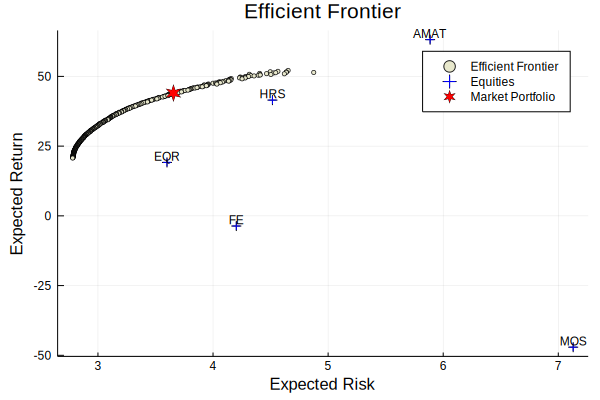

In [23]:
# Plots the efficient frontier
efficient_frontier(p_array)

In [24]:
equity_performance(p_array)

,Equities,Weights,Expected_Return,Expected_Risk,Sharp_Ratio
,String,Float64,Float64,Float64,Float64
1,AMAT,0.446,63.1757,5.88623,10.7328
2,EQR,0.299,19.1607,3.59994,5.32251
3,FE,0.006,-3.6482,4.20228,-0.868148
4,HRS,0.247,41.496,4.51623,9.18821
5,MOS,0.002,-47.0855,7.12933,-6.60448


The above results suggest that resources should be allocated to AMAT, EQR and HRS respectively, with nothing going to FE and MOS.  

In [25]:
market_performance(p_array)

,Market_Portfolio,Expected_Return,Expected_Risk,Sharp_Ratio
,String,Float64,Float64,Float64
1,Market Portfolio,44.0148,3.65613,12.0386


The optimal portfolio should be expected to have 40 to 50 % return.